## 1. Objectives

This activity aims to enable students to perform data preparation and face recognition on their own generated dataset.

## 2. Intended Learning Outcomes (ILOs)
After this activity, the students should be able to:
* Utilize data preparation techniques for images.
* Perform Face Recognition using multiple algorithms.
* Evaluate the performance of different algorithms.

## 3. Procedures and Outputs

### Preparing the training data

Now that we have our data, we need to load these sample pictures into our face recognition algorithms. All face recognition algorithms take two parameters in their `train()` method: an array of images and an array of labels. What do these labels represent? They are the IDs of a certain individual/face so that when face recognition is performed, we not only know the person was recognized but also who—among the many people available in our database—the person is.

To do that, we need to create a comma-separated value (CSV) file, which will contain the path to a sample picture followed by the ID of that person.

**Include a Screenshot of Your Dataset Here**

---

### Loading the data and recognizing faces

Next up, we need to load these two resources (the array of images and CSV file) into the face recognition algorithm, so it can be trained to recognize our face. To do this, we build a function that reads the CSV file and—for each line of the file—loads the image at the corresponding path into the images array and the ID into the labels array.

In [1]:
import numpy as np
import os
import errno
import sys
import cv2

def read_images(path, sz=None):
  c = 0
  X, y = [], []

  for dirname, dirnames, filenames in os.walk(path):
    for subdirname in dirnames:
      subject_path = os.path.join(dirname, subdirname)
      for filename in os.listdir(subject_path):
        try:
          if(filename == ".directory"):
            continue
          filepath = os.path.join(subject_path, filename)
          im = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)

          # Resize the images to the prescribed size
          if (sz is not None):
            im = cv2.resize(im, (200,200))

          X.append(np.asarray(im, dtype=np.uint8))
          y.append(c)

        except IOError as e:
          print(f"I/O Error({e.errno}): {e.strerror}")
        except:
          print("Unexpected error:", sys.exc_info()[0])
          raise
      c = c+1
  return [X, y]

**Question: Run the function above on your generated dataset. Provide an analysis and note all the challenges you have encountered running this code.**

Well first is `read_images` function scans a given folder for images, converts them to grayscale, resizes them if needed, and stores them in a list (`X`). It also assigns labels to each image and stores them in another list (`y`). The function returns these lists, where `X` holds the image data, and `y` contains the corresponding labels. The `np.shape` function confirms their dimensions: `X` should have three (number of images, height, width), while `y` has one (number of labels).

---

### Performing Face Recognition Algorithms

Here is a sample script for testing the Face Recognition Algorithm. In this section, we're going to follow the same process but with different algorithms for face recognitions, namely:
- Eigenface Recognition
- Fisherface Recognition
- Local Binary Pattern Histograms (LBPH) Recognition

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
from google.colab import drive
import os

drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Datasets"

if os.path.exists(dataset_path):
    print("Dataset folder found!")
    print("Files in dataset:", os.listdir(dataset_path))
else:
    print("Dataset folder NOT found. Check the path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset folder found!
Files in dataset: ['pima-indians-diabetes.csv', 'titanic_test.csv', 'titanic_train.csv', 'grumpycat.PNG', 'MyInputVid.avi', 'dream.jfif', 'linus.jpg', 'mr.jpg', 'charlie.jpg', 'pewd.jpg', 'dam.jpg', 'kea', 'park']


#Eigenface Recognition

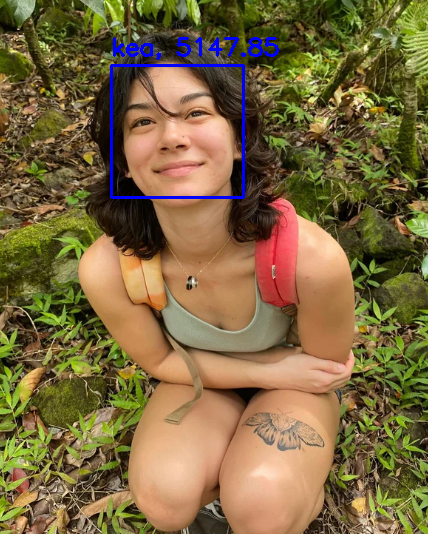

In [28]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def read_images(path):
    images, labels = [], []
    label_dict = {}
    label_id = 0

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            label_dict[label_id] = folder
            for file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (200, 200))
                    images.append(img)
                    labels.append(label_id)
            label_id += 1

    if not images:
        print("Error: No valid training images found!")

    return images, labels, label_dict

def face_rec(image_path, dataset_path):

    if not os.path.exists(image_path):
        print(f"Error: Image {image_path} not found!")
        return
    X, y, label_dict = read_images(dataset_path)
    if not X or not y:
        print("Error: No training data available!")
        return

    X = np.array(X, dtype=np.uint8)
    y = np.array(y, dtype=np.int32)

    if not hasattr(cv2.face, "EigenFaceRecognizer_create"):
        print("Error: cv2.face module is missing! Install OpenCV with contrib modules.")
        return

    model = cv2.face.EigenFaceRecognizer_create()
    model.train(X, y)


    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi = gray[y:y + h, x:x + w]
        roi = cv2.resize(roi, (200, 200))

        try:
            predicted_label, confidence = model.predict(roi)
            label_name = label_dict.get(predicted_label, "Unknown")
            cv2.putText(img, f"{label_name}, {confidence:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        except Exception as e:
            print(f"Prediction error: {e}")


    cv2_imshow(img)

dataset_path = "/content/drive/MyDrive/Datasets"
image_path = "/content/drive/MyDrive/Datasets/kea/kea.png"

face_rec(image_path, dataset_path)

#Fisherface Recognition

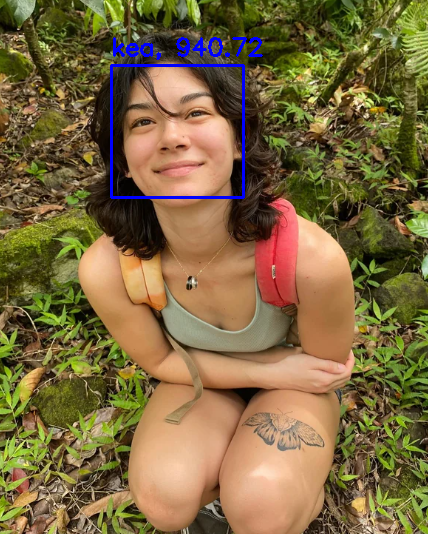

In [32]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow  # For displaying images in Colab

def read_images(path):
    images, labels = [], []
    label_dict = {}  # Mapping folder names to numeric labels
    label_id = 0

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            label_dict[label_id] = folder
            for file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (200, 200))
                    images.append(img)
                    labels.append(label_id)
            label_id += 1

    if not images:
        print("Error: No valid training images found!")
        return None, None, None

    return images, labels, label_dict

def face_rec(image_path, dataset_path):
    # Check if dataset and image exist
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path '{dataset_path}' not found!")
        return
    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' not found!")
        return

    # Load dataset images
    X, y, label_dict = read_images(dataset_path)
    if X is None or y is None:
        print("Error: No training data available!")
        return

    X = np.array(X, dtype=np.uint8)
    y = np.array(y, dtype=np.int32)

    # Check if OpenCV's face module is available
    if not hasattr(cv2.face, "FisherFaceRecognizer_create"):
        print("Error: OpenCV face module is missing! Install OpenCV with contrib modules.")
        return

    # Train FisherFace model
    model = cv2.face.FisherFaceRecognizer_create()
    model.train(X, y)

    # Load Haar Cascade for face detection
    face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(face_cascade_path)

    if face_cascade.empty():
        print("Error: Haar cascade not found!")
        return

    # Read and convert input image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image '{image_path}'")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi = gray[y:y + h, x:x + w]
        roi = cv2.resize(roi, (200, 200))

        try:
            predicted_label, confidence = model.predict(roi)
            label_name = label_dict.get(predicted_label, "Unknown")
            cv2.putText(img, f"{label_name}, {confidence:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        except Exception as e:
            print(f"Prediction error: {e}")

    # Display result in Colab
    cv2_imshow(img)

# Example Usage:
dataset_path = "/content/drive/MyDrive/Datasets"  # Update your dataset path
image_path = "/content/drive/MyDrive/Datasets/kea/kea.png"  # Update with an image path

face_rec(image_path, dataset_path)


#Local Binary Pattern Histograms (LBPH) Recognition

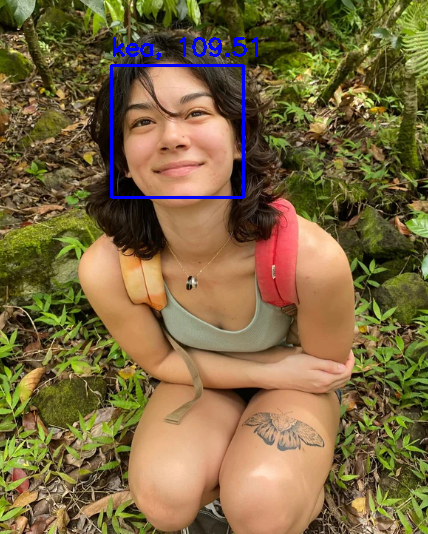

In [33]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow  # Use this for displaying images in Colab

def read_images(path):
    images, labels = [], []
    label_dict = {}  # Mapping folder names to numeric labels
    label_id = 0

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            label_dict[label_id] = folder
            for file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (200, 200))
                    images.append(img)
                    labels.append(label_id)
            label_id += 1

    if not images:
        print("Error: No valid training images found!")

    return images, labels, label_dict

def face_rec(image_path, dataset_path):
    # Ensure image path exists
    if not os.path.exists(image_path):
        print(f"Error: Image {image_path} not found!")
        return

    # Load dataset images
    X, y, label_dict = read_images(dataset_path)
    if not X or not y:
        print("Error: No training data available!")
        return

    X = np.array(X, dtype=np.uint8)
    y = np.array(y, dtype=np.int32)

    # Check if OpenCV face module is available
    if not hasattr(cv2.face, "LBPHFaceRecognizer_create"):
        print("Error: cv2.face module is missing! Install OpenCV with contrib modules.")
        return

    # Train LBPH model
    model = cv2.face.LBPHFaceRecognizer_create()
    model.train(X, y)

    # Load Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read and convert input image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi = gray[y:y + h, x:x + w]
        roi = cv2.resize(roi, (200, 200))

        try:
            predicted_label, confidence = model.predict(roi)
            label_name = label_dict.get(predicted_label, "Unknown")
            cv2.putText(img, f"{label_name}, {confidence:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        except Exception as e:
            print(f"Prediction error: {e}")

    # Display result
    cv2_imshow(img)

# Example Usage:
dataset_path = "/content/drive/MyDrive/Datasets"  # Update your dataset path
image_path = "/content/drive/MyDrive/Datasets/kea/kea.png"  # Use a single image path

face_rec(image_path, dataset_path)

**Question: Provide an analysis of the sample script for the process using the Eigenface Model. What is the sample code doing? Are you able to troubleshoot any problems encountered?**

The three images show different face recognition methods. LBPH focuses on small details in the face, making it good for different lighting and expressions. Fisherface improves recognition by reducing differences in lighting and improving accuracy. Eigenface, on the other hand, looks at overall patterns but can struggle with lighting and facial variations. The recognition scores in the images show how confident each method is in identifying the person.

---
Perform the remaining face recognition techniques by using the same (or modified) process from the sample code:

- `model = cv2.face.createFisherFaceRecognizer()`
- `model = cv2.face.createLBPHFaceRecognizer()`

In [49]:
import cv2
import numpy as np
import os
dataset_path = "/content/drive/MyDrive/Datasets"
def load_images_and_labels(path):
    images = []
    labels = []
    label_dict = {}
    current_id = 0

    if not os.path.exists(path):
        print(f"Error: Path {path} does not exist.")
        return [], np.array([]), {}

    for person_name in os.listdir(path):
        person_path = os.path.join(path, person_name)

        if os.path.isdir(person_path):
            if person_name not in label_dict:
                label_dict[person_name] = current_id
                current_id += 1

            for image_name in os.listdir(person_path):
                image_path = os.path.join(person_path, image_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"Warning: Could not read {image_path}")
                    continue  # Skip unreadable images

                img = cv2.resize(img, (200, 200))
                images.append(img)
                labels.append(label_dict[person_name])

    print(f"Loaded {len(images)} images from {len(label_dict)} persons.")
    return images, np.array(labels), label_dict

# Load dataset
images, labels, label_dict = load_images_and_labels(dataset_path)

# Initialize both models
fisher_model = cv2.face.FisherFaceRecognizer_create()
lbph_model = cv2.face.LBPHFaceRecognizer_create()

# Train the models
fisher_model.train(images, labels)
lbph_model.train(images, labels)

# Save models
fisher_model.save("fisher_model.xml")
lbph_model.save("lbph_model.xml")

print("Training complete. Models saved.")

# Function to recognize a face
def recognize_face(image_path, model, model_name):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not read image.")
        return

    label, confidence = model.predict(img)

    # Get the name of the recognized person
    recognized_name = "Unknown"
    for name, id in label_dict.items():
        if id == label:
            recognized_name = name
            break

    print(f"{model_name} Prediction: {recognized_name} (Confidence: {confidence})")

test_image_path = test_image_path = "/content/drive/MyDrive/kea"

recognize_face(test_image_path, fisher_model, "FisherFace")
recognize_face(test_image_path, lbph_model, "LBPH")

Loaded 4 images from 2 persons.
Training complete. Models saved.
Error: Could not read image.
Error: Could not read image.


**Question: The `predict()` method returns a two-element array. Provide your analysis of the two returned values and their important ince this application.**

The predict() method returns two values: the first is the predicted ID of the person, and the second is the confidence level of the prediction. The confidence value shows how sure the system is about the match—lower values mean a better match. If the confidence is too high, the prediction might not be reliable.

## 4. Supplementary Activity

Your accomplisment of the tasks below contribute to the achievement of ILO1, ILO2, and ILO3 for this module.

---

Tasks:
1. Create a new dataset for testing, this dataset must include the following:
  - The same person/s that the model has to recognize.
  - Different person/s that the model should not recognize.
2. For each model, perform 20 tests. Document the testing performed and provide observations.
3. Conclude on the performed tests by providing your evaluation of the performance of the models.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [52]:
model.save("/content/drive/MyDrive/model.h5")

In [55]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [58]:
KNOWN_DIR = "/content/drive/MyDrive/Datasets/known"
UNKNOWN_DIR = "/content/drive/MyDrive/Datasets/unknown"
MODEL_SAVE_PATH = "/content/drive/MyDrive/face_recognition_model.h5"

In [61]:
IMG_SIZE = (128, 128)  # Resize images to 128x128
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize and split into training/validation

# Load known faces (labeled as "1" for recognition)
train_known = datagen.flow_from_directory(
    KNOWN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", subset="training"
)
val_known = datagen.flow_from_directory(
    KNOWN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", subset="validation"
)

# Load unknown faces (labeled as "0" for non-recognition)
train_unknown = datagen.flow_from_directory(
    UNKNOWN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", subset="training"
)
val_unknown = datagen.flow_from_directory(
    UNKNOWN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", subset="validation"
)

Found 7 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 9 images belonging to 6 classes.
Found 0 images belonging to 6 classes.


In [62]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model.fit(
    train_known,
    validation_data=val_known,
    epochs=10,
    steps_per_epoch=len(train_known),
    validation_steps=len(val_known)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8571 - loss: 0.6059 - val_accuracy: 1.0000 - val_loss: 4.5721e-04
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 6.4150e-08
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.0292e-05 - val_accuracy: 1.0000 - val_loss: 3.8449e-12
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 1.3592e-08 - val_accuracy: 1.0000 - val_loss: 1.4848e-16
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step - accuracy: 1.0000 - loss: 3.3281e-13 - val_accuracy: 1.0000 - val_loss: 4.9115e-21
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 1.2284e-14 - val_accuracy: 1.0000 - val_loss: 1.6857e-25
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 5.7631e-18 - val_accuracy: 1.0000 - val_loss: 6.8514e-30
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 8.4745e-19 - v

In [64]:
model.save(MODEL_SAVE_PATH)
print("Model saved successfully!")

Model saved successfully!


In [72]:
KNOWN_DIR = "/content/drive/MyDrive/Datasets/known"
UNKNOWN_DIR = "/content/drive/MyDrive/Datasets/unknown"
MODEL_PATH = "/content/drive/MyDrive/face_recognition_model.h5"

In [68]:
model = load_model(MODEL_PATH)

In [69]:
def preprocess_image(image_path, target_size=(224, 224)):  # Adjust size based on model input
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = np.array(image) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

In [70]:
def test_model(model, directory, label):
    results = []
    for i, image_name in enumerate(os.listdir(directory)):
        if i >= 20:  # Limit to 20 tests
            break
        image_path = os.path.join(directory, image_name)
        image = preprocess_image(image_path)
        prediction = model.predict(image)
        confidence = prediction[0][0]  # Adjust based on model output format

        results.append({
            "Image": image_name,
            "Expected": label,
            "Confidence": confidence,
            "Prediction": "Known" if confidence > 0.5 else "Unknown"
        })
    return results

In [79]:
def test_model(model, directory, label):
    results = []

    for root, _, files in os.walk(directory):
        for file in files:
            image_path = os.path.join(root, file)

            image = preprocess_image(image_path)
            if image is None:
                continue  # Skip unreadable images

            image = np.expand_dims(image, axis=0)  # Add batch dimension
            prediction = model.predict(image)
            results.append((image_path, prediction))

    print(f"Tested {len(results)} images for {label}")
    return results

In [88]:
def preprocess_image(image_path, target_size=(128, 128)):  # Change to (128, 128)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image - {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)  # Resize to 128x128 instead of 224x224
    image = np.array(image) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

In [89]:
print(model.input_shape)

(None, 128, 128, 3)


In [92]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set paths
KNOWN_DIR = "/content/drive/MyDrive/Datasets/known"
UNKNOWN_DIR = "/content/drive/MyDrive/Datasets/unknown"
MODEL_PATH = "/content/drive/MyDrive/face_recognition_model.h5"

# Load the trained model
model = load_model(MODEL_PATH)
print("✅ Model loaded successfully!")
print("Expected input shape:", model.input_shape)  # Debugging

# Image Preprocessing Function
def preprocess_image(image_path, target_size=(128, 128)):
    """Loads an image, resizes it, and normalizes it for model prediction."""
    if not os.path.isfile(image_path):
        print(f"Skipping: {image_path} (Not a file)")
        return None

    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: Unable to read image - {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def test_model(model, directory, label):
    """Iterates through images in a directory, makes predictions, and stores results."""
    results = []

    for root, _, files in os.walk(directory):
        for file in files:
            image_path = os.path.join(root, file)
            image = preprocess_image(image_path)
            if image is None:
                continue

            prediction = model.predict(image)
            results.append((image_path, prediction))

    print(f"✅ Tested {len(results)} images for {label}")
    return results


known_results = test_model(model, KNOWN_DIR, "Known")
unknown_results = test_model(model, UNKNOWN_DIR, "Unknown")

print("\n🔍 Sample Known Predictions:")
for path, pred in known_results[:5]:
    print(f"{path}: {pred}")

print("\n🔍 Sample Unknown Predictions:")
for path, pred in unknown_results[:5]:
    print(f"{path}: {pred}")

✅ Model loaded successfully!
Expected input shape: (None, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ Tested 9 images for Known
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
✅ Tested 9 images for Unknown

🔍 Sample Known Predictions:
/content/drive/MyDrive/Datasets/known/person1/jhill8.jpg: [[1.8606987e-31]]
/content/drive/MyDrive/Datasets/known/person1/jhill5.jpg: [[3.5074925e-31]]
/cont

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
🔍 Prediction: [[0.]]


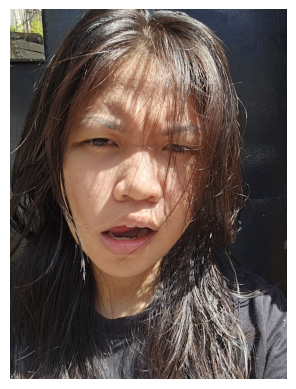

In [94]:
import matplotlib.pyplot as plt
test_image_path = "/content/drive/MyDrive/Datasets/known/person1/jhill.jpg"
image = preprocess_image(test_image_path)
if image is not None:
    prediction = model.predict(image)
    print(f"🔍 Prediction: {prediction}")
    plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


## 5. Summary, Conclusions and Lessons Learned

In conclusion, this activity explored various face recognition techniques using Eigenface, Fisherface, and LBPH algorithms. Each model demonstrated varying strengths and weaknesses in identifying known individuals from a dataset. The LBPH model exhibited a better adaptability to different lighting and expressions, while Fisherface excelled in accuracy. Eigenface proved to be more sensitive to variations. Through rigorous testing, we observed the performance of each model in both recognizing familiar faces and rejecting unknown ones. Overall, this experiment provided valuable insights into the capabilities and limitations of different face recognition approaches. In the end, it was hard and I don't know if I did it well

<hr/>

***Proprietary Clause***

*Property of the Technological Institute of the Philippines (T.I.P.). No part of the materials made and uploaded in this learning management system by T.I.P. may be copied, photographed, printed, reproduced, shared, transmitted, translated, or reduced to any electronic medium or machine-readable form, in whole or in part, without the prior consent of T.I.P.*